# Models to predict second loan repayment based on first loan characteristics

In [63]:
# import relevant modules
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import math
import datetime as dt
from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV

from scipy import stats

In [64]:
# Imported data used for cross correlation (pair) plots in Zidisha_Features_Models
# generated in ZidishaNotebook_FeatureExploration_Models_iMac
# note that late_y is whether the first loan was late at 6 months

firstLoan_secondLabel = pd.read_csv('firstLoan_labelsFromSecondLoan.csv')
firstLoan_secondLabel.drop('Unnamed: 0', axis = 1, inplace = True)
firstLoan_secondLabel.head(2)

,borrower_id,proposal_x,proposal_y,late_x,loan_amt,td_median,td_std,td_skew,td_kurt,paid_diff_std,...,loan_id,time_diff,usd_amount,lender_interest_rate,time_app_disb,appl_month,disb_month,applied_at,currency_code,late_y
0,32768,Dear lenders first for all is to thank the Zid...,My second loan i intend to use it by....\r\n1....,0,78,0,2.110579,-2.84605,6.1,0,...,16330,0,78,0,11,4,4,2015-04-11,KES,0
1,32774,If and when my loan is fully funded i will be ...,when and if my loan project is fully funded i ...,0,100,0,0.000000,0.00000,-3.0,0,...,15006,0,100,0,12,3,3,2015-03-08,GHS,0


In [65]:
labels = firstLoan_secondLabel.late_x

X = firstLoan_secondLabel[['td_median', 'td_std', 'td_skew', 'td_kurt', 'paid_diff_std',
       'loan_ratio','applied_time_diff', 'prop_len_rat', 'time_diff',
       'usd_amount', 'lender_interest_rate', 'time_app_disb']]

# The first five columns, as well as usd_amt, and lender_interest_rate are from the first loan

# Split features and labels into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=0)

In [66]:
rf = RandomForestClassifier(n_estimators=100,max_depth=10)
rf.fit(X_train, y_train)
predicted = rf.predict(X_test)
probs = rf.predict_proba(X_test)
# check the accuracy on the training set
rf.score(X_train, y_train)

0.89673581452104945

In [67]:
print "Accuracy on test set is: " + str(metrics.accuracy_score(y_test, predicted))
print "Precision is: " + str(metrics.precision_score(y_test, predicted))
print "Recall is: " + str(metrics.recall_score(y_test, predicted))
print "Area under ROC-curve is: " + str(metrics.roc_auc_score(y_test, probs[:, 1]))
print "Classification Report: \n", metrics.classification_report(y_test, predicted)

Accuracy on test set is: 0.853380782918
Precision is: 0.883064516129
Recall is: 0.669042769857
Area under ROC-curve is: 0.91400515627
Classification Report: 
             precision    recall  f1-score   support

        0.0       0.84      0.95      0.89      1828
        1.0       0.88      0.67      0.76       982

avg / total       0.86      0.85      0.85      2810



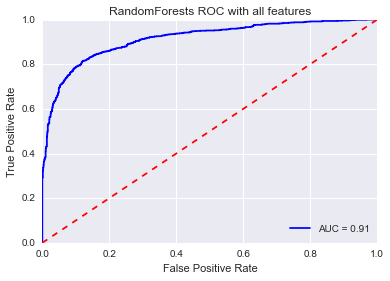

In [68]:
fpr, tpr, threshold = metrics.roc_curve(y_test, probs[:, 1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('RandomForests ROC with all features')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [69]:
gs_params = {'n_estimators': [100, 200, 500],
             'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': [10, 20, 50]}

rfc = RandomForestClassifier()

cv = GridSearchCV(estimator=rfc, param_grid = gs_params, scoring = 'roc_auc')

cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

0.941268676935
{'max_features': 'auto', 'n_estimators': 500, 'max_depth': 50}


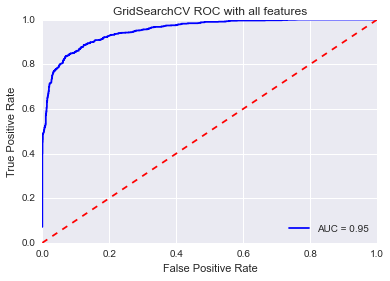

In [70]:
print cv.best_score_
print cv.best_params_

preds = cv.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('GridSearchCV ROC with all features')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [71]:
predicted = cv.predict(X_test)
probs = cv.predict_proba(X_test)

print "Accuracy on test set is: " + str(metrics.accuracy_score(y_test, predicted))
print "Precision is: " + str(metrics.precision_score(y_test, predicted))
print "Recall is: " + str(metrics.recall_score(y_test, predicted))
print "Area under ROC-curve is: " + str(metrics.roc_auc_score(y_test, probs[:, 1]))
print "Classification Report: \n", metrics.classification_report(y_test, predicted)

Accuracy on test set is: 0.893238434164
Precision is: 0.880580357143
Recall is: 0.803462321792
Area under ROC-curve is: 0.953454299937
Classification Report: 
             precision    recall  f1-score   support

        0.0       0.90      0.94      0.92      1828
        1.0       0.88      0.80      0.84       982

avg / total       0.89      0.89      0.89      2810



In [112]:
gs_params1 = {'n_estimators': [50, 100, 200],
             'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth': [5, 10, 20]}

rfc1 = RandomForestClassifier()

cv1 = GridSearchCV(estimator=rfc, param_grid = gs_params1, scoring = 'roc_auc')

cv1.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)

0.939937721192
{'max_features': 'sqrt', 'n_estimators': 200, 'max_depth': 20}


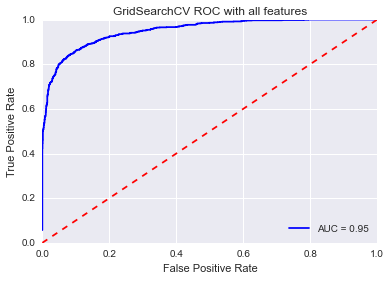

In [113]:
print cv1.best_score_
print cv1.best_params_

preds1 = cv1.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds1)
roc_auc = metrics.auc(fpr, tpr)

plt.title('GridSearchCV ROC with all features')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [45]:
# Do RF without grid search

rfc2 = RandomForestClassifier(max_features= 'sqrt', n_estimators= 200, max_depth= 20)
rfc2.fit(X_train, y_train)
predicted4 = rfc2.predict(X_test)
probs4 = rfc2.predict_proba(X_test)
# check the accuracy on the training set
rfc2.score(X_train, y_train)


0.986424649176327

In [49]:
importances = pd.DataFrame(zip(X.columns, np.transpose(rfc2.feature_importances_)))
importances.columns = ['feature_name', 'weight']
importances

,feature_name,weight
0,td_median,0.087667
1,td_std,0.111757
2,td_skew,0.074902
3,td_kurt,0.082679
4,paid_diff_std,0.008617
5,loan_ratio,0.129797
6,applied_time_diff,0.121179
7,prop_len_rat,0.095167
8,time_diff,0.044149
9,usd_amount,0.098463


In [56]:
importances = importances.sort(columns = 'weight', ascending = False)

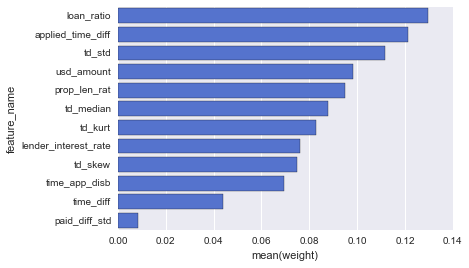

In [62]:
g = sns.barplot(x = 'weight', y = 'feature_name', data = importances, orient = 'h', color = 'royalblue')

In [15]:
print "Classification Report: \n", metrics.classification_report(y_test, predicted4)

Classification Report: 
             precision    recall  f1-score   support

        0.0       0.90      0.94      0.92      1828
        1.0       0.89      0.80      0.84       982

avg / total       0.89      0.89      0.89      2810



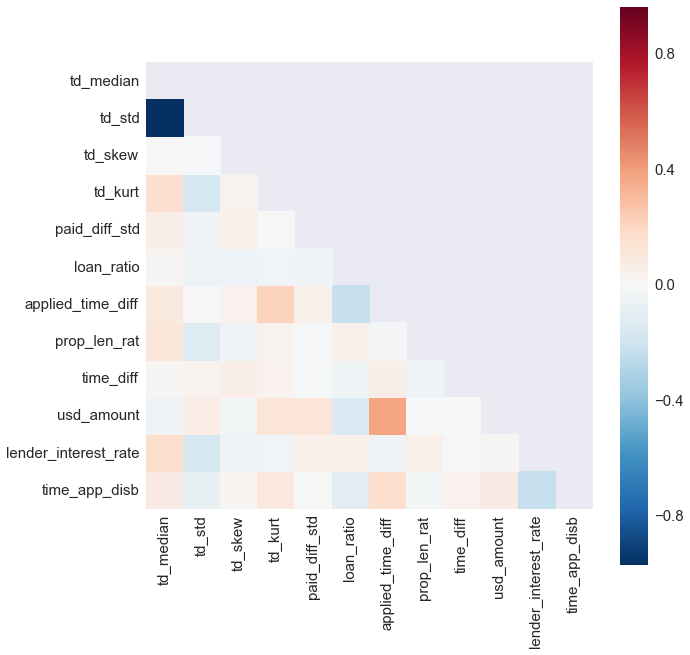

In [17]:
# Sanity check:
# Correlation between different parameters
sns.set(font_scale=1.5)
# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap using seaborn
sns.heatmap(corr, mask = mask, vmax=.8, square=True)

# Draw the heatmap with the mask and correct aspect ratio
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
           # square=True, xticklabels=2, yticklabels=2,
           # linewidths=.5,cbar_kws={"shrink": .75}, ax=ax)

# Logistic Regression

In [5]:
Xlr = firstLoan_secondLabel[['td_std', 'loan_ratio', 'applied_time_diff', 'usd_amount']]
Xlr_norm = preprocessing.normalize(Xlr)
labels = firstLoan_secondLabel.late_x

# Split features and labels into train and test sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(Xlr_norm, labels, test_size=0.3, random_state=0)

In [7]:
model = LogisticRegression()
model = model.fit(X_train_lr, y_train_lr)
print model.score(X_train_lr, y_train_lr)
lrpredicted = model.predict(X_test_lr)
lrprobs = model.predict_proba(X_test_lr)
print metrics.classification_report(y_test_lr, lrpredicted)

0.627364246492
             precision    recall  f1-score   support

        0.0       0.66      0.96      0.78      1828
        1.0       0.54      0.08      0.14       982

avg / total       0.62      0.65      0.56      2810



In [45]:
LR1 = pd.DataFrame(zip(Xlr.columns, np.transpose(model.coef_)))
LR1.columns = ['feature_name', 'weight_1']
LR1

,feature_name,weight_1
0,td_std,[-0.0458158413392]
1,loan_ratio,[1.32415275989]
2,applied_time_diff,[0.610422780028]
3,usd_amount,[1.86752679735]


In [17]:
# Do RF without grid search

rfc3 = RandomForestClassifier(max_features= 'sqrt', n_estimators= 200, max_depth= 20)
rfc3.fit(X_train_lr, y_train_lr)
predicted_small = rfc3.predict(X_test_lr)
probs_small = rfc3.predict_proba[:1](X_test_lr)
# check the accuracy on the training set
rfc3.score(X_train_lr, y_train_lr)


0.98428920073215376

In [18]:
print metrics.classification_report(y_test_lr, predicted_small)

             precision    recall  f1-score   support

        0.0       0.89      0.91      0.90      1828
        1.0       0.83      0.79      0.81       982

avg / total       0.87      0.87      0.87      2810



In [19]:
importances_small = pd.DataFrame(zip(Xlr.columns, np.transpose(rfc3.feature_importances_)))
importances_small.columns = ['feature_name', 'weight']
importances_small

,feature_name,weight
0,td_std,0.253371
1,loan_ratio,0.294095
2,applied_time_diff,0.229535
3,usd_amount,0.223000


In [20]:
rfc3.feature_importances_

array([ 0.25337071,  0.29409502,  0.22953458,  0.22299969])

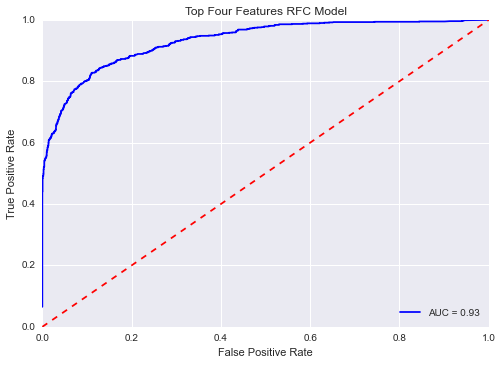

In [25]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_lr, probs_small[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Top Four Features RFC Model')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()